# Combined leaf and wood Xylariaceae analysis

We will use our combined biom table of leaf and wood endophytes to ask some questions about the roles of both leaf- and sapwood-inhabiting endophytes on nearby stromata, focusing on the family Xylariaceae.

<a id='contents'></a>

## Contents

[Importing biom table and setup](#import)  
[Negative control cleanup](#nc)  
[Variance Stabilization of Read Counts](#deseq)  

<a id='import'></a>

## Importing biom table and setup

Let's get the proper packages and import our biom table.

In [14]:
library('phyloseq')
library('DESeq2')
library('repr')

Import our biom table. We used the green genes style of formatting for our taxonomy metadata, I think...

In [5]:
biom95 <- import_biom('combo_95_wMeta.biom', parseFunction=parse_taxonomy_greengenes)

Our biom table:

In [6]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10269 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10269 taxa by 7 taxonomic ranks ]

<a id='nc'></a>

## Cleanup of biom tables using negative control

Okay, as per the recommendations of [Nguyen 2015](http://onlinelibrary.wiley.com/doi/10.1111/nph.12923/full), we'll remove sequences of OTUs found in our negative controls, up to the amount of reads found for these OTUs in our negative control. 

What do we find in our negatives? Make a phyloseq object of just our negative:

In [8]:
neg95 <- subset_samples(biom95, SampleNumber=='Neg')

In [9]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10269 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10269 taxa by 7 taxonomic ranks ]

How many contaminants do we have? Total reads:

In [11]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1757

Which OTUs, and how many of each?

In [10]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU66:65Leaf     OTU39:65Leaf  OTU1732:163wood OTU199:112.2Leaf 
             543               98                1               40 
  OTU623:114Leaf   OTU206:161wood   OTU695:164wood   OTU237:161wood 
              61                1               69              109 
    OTU77:12Leaf   OTU132:104Leaf    OTU89:161wood   OTU185:161wood 
               1               56                3                2 
  OTU161:161wood   OTU106:122Leaf    OTU181:70Leaf   OTU256:161wood 
               1                2                1              108 
  OTU198:161wood   OTU444:161wood   OTU782:192wood     OTU47:51Leaf 
               1               51                1                1 
  OTU291:167wood   OTU313:164wood   OTU343:164wood   OTU234:165wood 
               1               20                1                1 
    OTU16:14Leaf   OTU308:173wood    OTU204:35Leaf     OTU18:55Leaf 
               1                1                1                1 
   OTU19:100Leaf   OTU521:132Leaf  OTU1193:103Leaf  OTU1436:172wood 
               1                1               36               64 
  OTU240:167wood    OTU167:90Leaf  OTU1283:170wood  OTU2363:168wood 
             185                1                4                4 
  OTU747:254wood    OTU63:194wood   OTU2828:34Leaf  OTU1444:255wood 
               1               13                1               50 
 OTU1066:125Leaf   OTU806:121Leaf  OTU1103:172wood  OTU1768:252wood 
               1               60               48                1 
 OTU1337:240wood   OTU5161:51Leaf  OTU8871:173wood    OTU727:48Leaf 
              32               23                1                1 
  OTU471:190wood  OTU1554:183wood  OTU1189:199wood    OTU30:207wood 
               1                1               44                3 
  OTU766:252wood  OTU1781:253wood 
               1                2

A quick summary of the top 15 contaminants:

In [12]:
aa <- taxa_sums(neg95)[taxa_sums(neg95)>0]
aa <- sort(aa, decreasing = TRUE)[1:15]
neg95_top15 <- prune_taxa(names(aa), neg95)

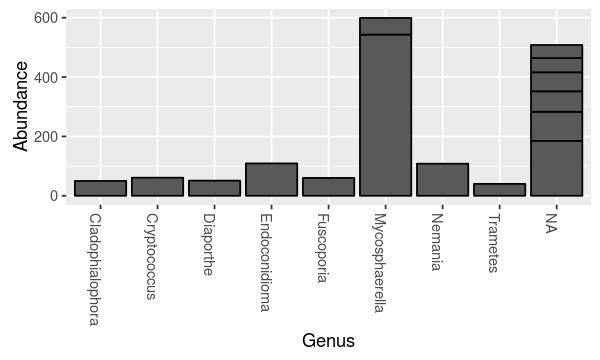

In [16]:
options(repr.plot.width = 5, repr.plot.height = 3) ## using repr to control size of R plotter outputs
plot_bar(neg95_top15, "Genus")

<a id='deseq'></a>

## Variance stabilization of our reads

It's important to [stabilize the variance](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531of) of our combined-leaf-and-wood-endophyte read depths, using the [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) package in R. This is a way of making the samples, which have highly variable numbers of reads in them, comparable for downstream statistical analyses.

Here is our current metadata for samples. We can subset by library type (leaf or wood), sample or control, and sample number. The unique identifiers (first column) were the name of the sample assigned by the illumina software.

In [9]:
head(sample_data(biom95))

,SampleNumber,SorC,Library
160wood,Dc-X,Control,W
161wood,Dc-PosG,Control,W
162wood,Dc-PosI,Control,W
163wood,Dc-Neg,Control,W
164wood,1,Sample,W
165wood,2,Sample,W


For the moment, we will repeat Roo's pipeline that he used to lay the groundwork for his other analyses with the leaf-only data. We want to treat this new data as similarly as possible. His first step was to remove controls and low-read (<2000) samples. 

How many samples have less than 2000 reads in our biom table?

In [15]:
sample_sums(biom95)[sample_sums(biom95) < 2000]

255wood    86Leaf    18Leaf    67Leaf 112_1Leaf 113_2Leaf    74Leaf 113_1Leaf 
     1757      1529      1402      1958         3         6       325        54 
126_2Leaf    91Leaf     Strom 
        5         6        51

Not many. Most of these needed to be removed anyway. 

In [16]:
biom95_hiread <- prune_samples(sample_sums(biom95)>=2000, biom95)

Did this work? 

In [17]:
sample_sums(biom95_hiread)[sample_sums(biom95_hiread) < 2000]

named numeric(0)

Nada. Worked. Now remove controls:

In [18]:
biom95_hiread_nocontrol <- subset_samples(biom95_hiread, SorC=="Sample")

In [20]:
head(sample_data(biom95_hiread_nocontrol)); tail(sample_data(biom95_hiread_nocontrol))

,SampleNumber,SorC,Library
164wood,1,Sample,W
165wood,2,Sample,W
166wood,3,Sample,W
167wood,4,Sample,W
168wood,5,Sample,W
169wood,7,Sample,W


,SampleNumber,SorC,Library
47Leaf,47,Sample,L
39Leaf,39,Sample,L
5Leaf,5,Sample,L
28Leaf,28,Sample,L
19Leaf,19,Sample,L
3Leaf,3,Sample,L


Roo has written a function to stream-line the process of using deseq variance stabilization, because it was originally written for RNA-seq data, with dense matrices. Species matrices are usually pretty sparse, so deseq needs a few workarounds to handle our kind of data. Thankfully, Roo has worked on this, and saved me probably weeks of work. Function looks like this: 


In [21]:
DESeq_varstab <- function(phyloseq, design) {
# phyloseq = the input phyloseq object that you want to get DESeq transformed counts for
# design_variable = the design for the conversion to the DESeq object. must be in the form "as a function of", for example "~Host_Genus", must be a variable in the phyloseq object

        # Set variables to NULL
        deseq.vst = NULL
        geo_Means = NULL
        phyloseq.DESeq = NULL

        # Convert to a DESeq object
        deseq = phyloseq_to_deseq2(phyloseq, design)

        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
                exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
                }

        geo_Means = apply(counts(deseq), 1, gm_mean)

        # Check to see if any columns (samples) don't have any OTUs in them:
        if(sum(colSums(counts(deseq)) == 0) == 0) { # if all samples have taxa, go on

                # Now we step through the size factors, dispersions, and varience stabilization:
                deseq = estimateSizeFactors(deseq, geoMeans = geo_Means)
                deseq = estimateDispersions(deseq) # long step
                deseq.vst = getVarianceStabilizedData(deseq)

                # replace negatives with zeros
                deseq.vst[deseq.vst <0] <- 0

                # add the varience stabilized otu numbers into the dataset:
                otu_table(phyloseq) <- otu_table(deseq.vst, taxa_are_rows = TRUE)

                # create a new object for the varience stabalized set
                phyloseq -> phyloseq.DESeq

                # And, filter any taxa that became 0s all the way across
                phyloseq.DESeq = filter_taxa(phyloseq.DESeq, function(x) sum(x) > 0.1, T)

                # return the new phyloseq object
                return(phyloseq.DESeq)

        } # end of IF loop 
        else {return("Error: your phyloseq object has samples with no taxa present.")}

} # end function


Try it out on our data:

In [12]:
## match Roo's random seed set, not sure if this is necessary for DeSeq but let's err on the side of caution
set.seed(28132)